# Make a Transient Model of the Rattlesnake Drainage
Here, we will construct a transient model of the Rattlesnake Drainage using mfnwt with the sfr and ufz packages. First we need to import libraries and then define important paths and file names.  These paths need to be modified for a particular machine the model and data reside on.

In this iteration, I will run a steady model first, and use that output as the starting values for head in the transient model.  As it seems it is starting over from strt for the transient simulation right now.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import flopy
from gsflow.builder import GenerateFishnet, FlowAccumulation
from gsflow.builder import ModflowBuilder
import pdb
import datetime as dt
from flopy.utils.geometry import Polygon
from flopy.utils.gridintersect import GridIntersect
import shapefile as sf
import xarray as xr
from flopy.utils.sfroutputfile import SfrFile
from flopy.utils.geometry import Point
import pandas as pd

#################################################
# Input path management
##################################################

# set our cell size in meters.  #I'll start out with 100m for now, but will likely refine
cellsize=100
method = "nearest"

#model name
model_name = "RattlesnakeCreek_%3im"%cellsize+method

# set the path to the top level
top_path = os.getcwd()
# set the path for gis data
gis_data_path = os.path.join(top_path,"data","gis")
# set path for infiltration data
snodas_path = os.path.join(top_path,"data","SNOWDAS")
# set path for PET
pet_path = os.path.join(top_path,"data","ET")
#toplevel ouput path
model_path = os.path.join(top_path,"models",model_name)

#derived output path
gis_derived_path = os.path.join(model_path,"gis_deriv")
#file names
dfname = "DEMResampledFA.txt"
watershedname = "watershed.txt"
gridname = "grid.bin"
streamfilename = "streams.bin"
snodas_file = 'snodas_infiltration_time_series.nc'
cnst_hd_shp = 'ConstantHEadBoundary.shp'
Gage_loc = 'GreenoughStreamGageLocation.shp'

## set the path to the mfnwt executable 
   # This either needs to be hardcoded, be in the system path, or be
   # in same directory as scripts.

## shapefile pour point
dem_file = os.path.join(gis_derived_path, dfname)
watershed_file = os.path.join(gis_derived_path, watershedname)
mg_file = os.path.join(model_path, gridname)

# define the stream information binary data path
stream_file = os.path.join(model_path, streamfilename)
constant_head_file = os.path.join(gis_data_path,cnst_hd_shp)
gage_file = os.path.join(gis_data_path,Gage_loc)
#######################################################
#Load Data
#######################################################
# load modelgrid, dem, watershed, and stream information file
modelgrid = GenerateFishnet.load_from_file(mg_file)
dem_data = np.genfromtxt(dem_file)
watershed = np.genfromtxt(watershed_file, dtype=int)
strm_obj = FlowAccumulation.load_streams(stream_file)

#######################################################
#Build Initial MODFLOW model in one step
#######################################################
# create a new modflow builder object
mfbuild = ModflowBuilder(modelgrid, dem_data, model_name)

########
#1 Layer for now
########
# set the botm elevation to be 100 m less than the top
botm = dem_data - 100
# reshape the array to (nlay,nrow,ncol)
botm.shape = (1, modelgrid.nrow, modelgrid.ncol)

# build the model
mf = mfbuild.build_all(
    strm_obj.reach_data,
    strm_obj.segment_data,
    strm_obj.irunbnd,
    finf=np.ones(dem_data.shape),
    botm=botm,
    ibound=watershed,
    iuzfbnd=watershed
)


## Modifying the initial model
Our initial model was built using the gsflow mfbuil.build_all() utility which builds out an initial model with somewhat sensible defaults.  We now need to go in an change all the defaults for our particular model. We'll start off by making the model three layers. and adding the transient stress periods.  First we'll print off information and current setting for the discretization package.

In [2]:
# Print out current discretization package information and set parameters
mf.dis


    MODFLOW Discretization Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.Modflow`) to which
        this package will be added.
    nlay : int
        Number of model layers (the default is 1).
    nrow : int
        Number of model rows (the default is 2).
    ncol : int
        Number of model columns (the default is 2).
    nper : int
        Number of model stress periods (the default is 1).
    delr : float or array of floats (ncol), optional
        An array of spacings along a row (the default is 1.0).
    delc : float or array of floats (nrow), optional
        An array of spacings along a column (the default is 0.0).
    laycbd : int or array of ints (nlay), optional
        An array of flags indicating whether or not a layer has a Quasi-3D
        confining bed below it. 0 indicates no confining bed, and not zero
        indicates a confining bed. LAYCBD for the bottom layer must be 0. (the
    

In [3]:
##################################################
# Modify Discretization package for three layers
##################################################
#set up for multiple layers
#number of layers
nlay=1
# layer thicknesses
lay1 = 2
lay2 = 10
lay3 = 100
barray = np.array([lay1,lay2,lay3])

#change bottom elevations
botm=np.zeros((nlay, mf.dis.nrow, mf.dis.ncol))
botm[0,:,:]=mf.dis.top.array-barray.sum()

#change layer cbd (confined boundary at bottom
laycbd=np.zeros((nlay))


### Time control
This is a critical component of the transient model.  How long to simulation?  How many stress periods?  What time step?  So many decisions.  I'm going to start by simulating water 22-23, with weekly stress periods, ~12 hour time steps.  These values may all need to change depending upon numerical stability.

In [4]:
##################################################
# Modify Discretization package for transient periods
##################################################

# Start Date - just for record keeping in the notebook and in the model.
start_date_ss = '10-1-2015'
start_date = '10-1-2016'

# End Date - just for record keeping in the notebook and in the model.
end_date = '9-30-2023'



# convert start_date and end_date to datetime objects
date_format = '%m-%d-%Y'
start_date = dt.datetime.strptime(start_date, date_format)
start_date_ss = dt.datetime.strptime(start_date_ss, date_format)
end_date = dt.datetime.strptime(end_date, date_format)

# total days in the simulation
total_time = (end_date-start_date).days

# stress period duration
perlen = int(7) # 1 week

# number of stress periods
nper = total_time//perlen + 1

# number of time steps per stress period
ts = 8 #hours
ts = ts/24 #days
nstp = int(perlen//ts)

print("Number of Stress Periods: ", nper)
print("Number of Time Steps per Stress Period: ", nstp)
print("Stress Period Duration: (days)", perlen)
print("Time Step Duration: (days)", ts)

# Can't make it start from steady state output - weird, so set a longer first stress period
first_perlen = 365
first_nstp = 365 # might need to change

# make an array of length nper with integer values equal to perlen
perlen_array = np.full(nper, perlen, dtype=int)
perlen_array[0] = first_perlen

# make an array of length nper with integer values equal to nstp
nstp_array = np.full(nper, nstp, dtype=int)
nstp_array[0] = first_nstp

# make a boolean array of length nper with all values set to False
steady_array = np.full(nper, False, dtype=bool)
#steady_array[0] = True

Number of Stress Periods:  366
Number of Time Steps per Stress Period:  21
Stress Period Duration: (days) 7
Time Step Duration: (days) 0.3333333333333333


In [5]:
total_time

2555

In [6]:
# create discretization object with updated parameters
dis = flopy.modflow.ModflowDis(
    mf,
    nlay=nlay,
    nrow=mf.dis.nrow,
    ncol=mf.dis.ncol,
    nper=nper,
    delr=mf.dis.delr,
    delc=mf.dis.delc,
    laycbd=laycbd,
    top=mf.dis.top,
    botm=botm,
    perlen= perlen_array,
    nstp= nstp_array,
    tsmult=1.0,
    steady= steady_array,
    itmuni=mf.dis.itmuni,
    lenuni=mf.dis.lenuni
)

c:\Users\taylo\anaconda3\envs\flopy_forge\Lib\site-packages\flopy\mbase.py:659: UserWarning: Unit 11 of package DIS already in use.
  warn(
c:\Users\taylo\anaconda3\envs\flopy_forge\Lib\site-packages\flopy\mbase.py:668: UserWarning: Two packages of the same type, Replacing existing 'DIS' package.
  warn(


### Layer Parameterization
Here we need to parameterize our watershed with groundwater flow parameters.  This is an extremely important step, and probably the one where we make the most error into our model.  For now, we will assume each layer is homogenous with reasonable parameters.  In reality, the world is not homogenous...

In [7]:
# Print out current upw package information
mf.upw


    Upstream weighting package class


    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.mf.Modflow`) to which
        this package will be added.
    ipakcb : int, optional
        Toggles whether cell-by-cell budget data should be saved. If None or zero,
        budget data will not be saved (default is None).
    hdry : float
        Is the head that is assigned to cells that are converted to dry during
        a simulation. Although this value plays no role in the model
        calculations, it is useful as an indicator when looking at the
        resulting heads that are output from the model. HDRY is thus similar
        to HNOFLO in the Basic Package, which is the value assigned to cells
        that are no-flow cells at the start of a model simulation. (default
        is -1.e30).
    iphdry : int
        iphdry is a flag that indicates whether groundwater head will be set
        to hdry when the groundwater head is

In [8]:
##################################################
# Modify UPW package for multiple layers
##################################################
# types of aquifers (0 is confined, 1 is convertible)
lay1 = 1
laytyp = np.array([lay1])

# hydraulic conductivity array
hk_lay1 = 1e-4*86400 #m/d
hk_lay2 = 1e-6*86400 #m/d
hk_lay3 = 1e-7*86400 #m/d
hkarray = np.array([hk_lay1, hk_lay2, hk_lay3])
hk_avg = (hkarray*barray).sum()/barray.sum()
# horizontal average
hk = np.ones((nlay, mf.dis.nrow, mf.dis.ncol))*hk_avg

# specific storage
ss_lay1 = 1e-6
ss_lay2 = 1e-7
ss_lay3 = 1e-8
ssarray = np.array([ss_lay1, ss_lay2, ss_lay3])

# thickness weighted average I think is the correct way to do it
ss_avg = (ssarray*barray).sum()/barray.sum()
ss = np.ones((nlay, mf.dis.nrow, mf.dis.ncol))*ss_avg

# specific yield
sy_lay1 = 0.4
sy_lay2 = 0.1
sy_lay3 = 0.01
syarray = np.array([sy_lay1, sy_lay2, sy_lay3])
# total response derivation
sy_avg = syarray.sum()
# thickness weighted average
sy_avg = (syarray*barray).sum()/barray.sum()

sy = np.ones((nlay, mf.dis.nrow, mf.dis.ncol))*sy_avg

# layer vka
layvka = np.ones(nlay)

# set up new upw package
upw = flopy.modflow.ModflowUpw(
    mf,
    laytyp=laytyp,
    layvka=layvka,
    hk=hk,
    ss=ss,
    sy=sy,
)


c:\Users\taylo\anaconda3\envs\flopy_forge\Lib\site-packages\flopy\mbase.py:659: UserWarning: Unit 31 of package UPW already in use.
  warn(
c:\Users\taylo\anaconda3\envs\flopy_forge\Lib\site-packages\flopy\mbase.py:668: UserWarning: Two packages of the same type, Replacing existing 'UPW' package.
  warn(


### Initial Conditions and Active Cells

In [9]:
# Print out current bas package information
mf.bas6


    MODFLOW Basic Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.mf.Modflow`) to which
        this package will be added.
    ibound : array of ints, optional
        The ibound array (the default is 1).
    strt : array of floats, optional
        An array of starting heads (the default is 1.0).
    ifrefm : bool, optional
        Indication if data should be read using free format (the default is
        True).
    ixsec : bool, optional
        Indication of whether model is cross sectional or not (the default is
        False).
    ichflg : bool, optional
        Flag indicating that flows between constant head cells should be
        calculated (the default is False).
    stoper : float
        percent discrepancy that is compared to the budget percent discrepancy
        continue when the solver convergence criteria are not met.  Execution
        will unless the budget percent discrepancy is greate

#### Intersect Constant Head Boundary
Set constant head cells along outlet to Clark Fork.  First intersect to the shapefile then find those cells later in ibound.

In [10]:
#########
# read in shape file
#########

# read in shapefile
sf1 = sf.Reader(constant_head_file)
# get the first shape
first_shape = sf1.shapes()[0]
# get the first polygon
first_polygon = Polygon(first_shape.points)

# create intersect object
ix = GridIntersect(modelgrid,method='vertex')

# get intersecting cells
constHeadCells = ix.intersect(first_polygon)
pd.DataFrame(constHeadCells).head(3)

,cellids,ixshapes,areas
0,"(286, 113)",POLYGON ((272604.15665141435 5194854.623803019...,8.845292
1,"(286, 114)",POLYGON ((272672.6808591121 5194866.5410565315...,804.017373
2,"(286, 115)",POLYGON ((272716.42896823527 5194852.869772430...,23.532775


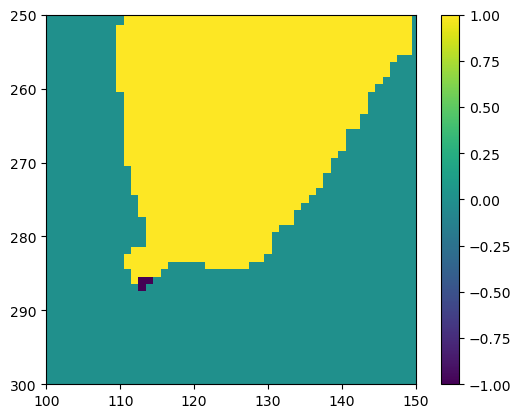

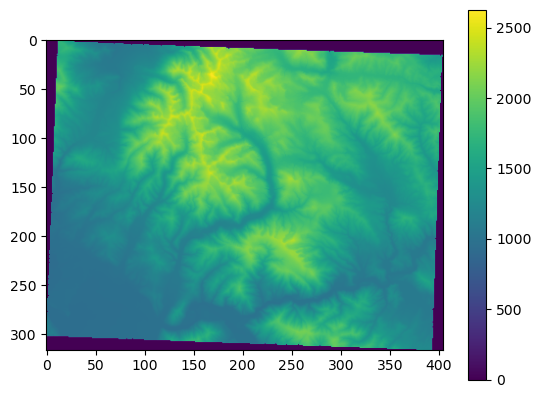

In [11]:
##################################################
# Modify BAS6 package for multiple layers
##################################################
# create ibound array for multiple layers
ibd1 = mf.bas6.ibound.array
ibound = np.zeros((nlay, mf.dis.nrow, mf.dis.ncol))
for i in range(nlay):
    ibound[i,:,:] = ibd1[0,:,:]

#constant head cells
for irow,icol in constHeadCells.cellids:
    for i in range(nlay): # all layers set to -1
        if ibound[i,irow,icol] == 1:
            ibound[i,irow,icol] = -1

plt.imshow(ibound[0,:,:])
plt.colorbar()
plt.xlim(100,150)
plt.ylim(300,250)
# create strt array for multiple layers
strt = np.ones((nlay, mf.dis.nrow, mf.dis.ncol))
for i in range(nlay):
    strt[i,:,:] = mf.dis.top.array - 5

plt.figure()
plt.imshow(mf.dis.top.array)
plt.colorbar()

In [12]:
# set up new bas6 package
bas6 = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt , stoper= 3.0)

c:\Users\taylo\anaconda3\envs\flopy_forge\Lib\site-packages\flopy\mbase.py:659: UserWarning: Unit 13 of package BAS6 already in use.
  warn(
c:\Users\taylo\anaconda3\envs\flopy_forge\Lib\site-packages\flopy\mbase.py:668: UserWarning: Two packages of the same type, Replacing existing 'BAS6' package.
  warn(


## Unsaturated Zone Packaage
This package controls much of our surface input interaction. Its very important.  Here is where we will need to interpolate our infiltration and ETR to our grid in space and time.

In [13]:
# print out current uzf package information
mf.uzf


    MODFLOW Unsaturated Zone Flow 1 Boundary Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.mf.Modflow`) to which
        this package will be added.
    nuztop : integer
        used to define which cell in a vertical column that recharge and
        discharge is simulated. (default is 1)

        1   Recharge to and discharge from only the top model layer. This
            option assumes land surface is defined as top of layer 1.
        2   Recharge to and discharge from the specified layer in variable
            IUZFBND. This option assumes land surface is defined as top of
            layer specified in IUZFBND.
        3   Recharge to and discharge from the highest active cell in each
            vertical column. Land surface is determined as top of layer
            specified in IUZFBND. A constant head node intercepts any recharge
            and prevents deeper percolation.

    iuzfopt : integer

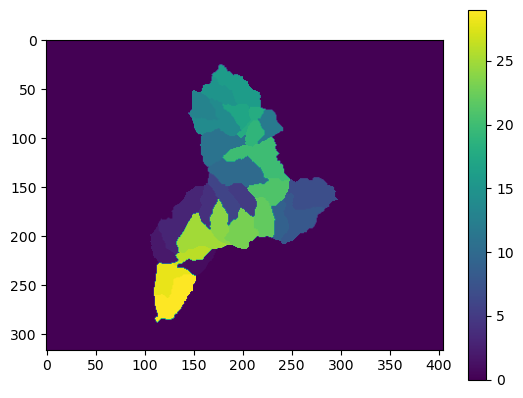

In [14]:
# take a look at the current surface runoff mapping in irunbnd
#plot strm_obj.irunbnd
plt.imshow(strm_obj.irunbnd)
plt.colorbar()

### Resample Infiltration
The infiltration netcdf was calculated from the entire SNODAS record.  It take all snowmelt and liquid precip and adds them.  The dataset set here is a netcdf with dimensions of time, x, y.  It includes all days in the SNODAS record.

In [15]:
#####################################################
# Resample Infiltration 
#####################################################

# Load the infiltration data into an xarray dataset
raster_ds = xr.open_dataset(os.path.join(snodas_path,snodas_file))
# convert all the -9999 values to nan in the raster data
raster_ds['raster_data'] = xr.where(raster_ds['raster_data'] <= -999, np.nan, raster_ds['raster_data'])
raster_ds

<xarray.Dataset>
Dimensions:      (time: 7451, x: 144, y: 101, data_type: 2)
Coordinates:
  * time         (time) datetime64[ns] 2003-09-30 2003-10-01 ... 2024-03-11
  * x            (x) float64 5.267e+06 5.266e+06 ... 5.153e+06 5.152e+06
  * y            (y) float64 2.314e+05 2.322e+05 ... 3.108e+05 3.116e+05
  * data_type    (data_type) object 'liquid_precip' 'melt'
Data variables:
    raster_data  (time, data_type, x, y) float64 nan nan nan nan ... nan nan nan

#### Calculate Infiltration
First convert to common length unit (m/d) and then add `melt` and `liquid_precip` together
##### Conversions
Liquid Precipitation is in $kg/m^2$, convert it to a length assuming $\rho_w = 1000kg/m^3$.  Don't forget the scale factors!  As described in the SNODAS data manual.  Weird random scaling number need to convert to the described unit.

In [16]:
# Multiply all values where datatype is 'liqui_precip' by the scale factor (1/10) and divide by the density 1000kg/m^3
raster_ds['raster_data'] = xr.where(raster_ds['data_type'] == 'liquid_precip', raster_ds['raster_data'] / 1e4, raster_ds['raster_data'])

raster_ds['raster_data'] = xr.where(raster_ds['data_type'] == 'melt', raster_ds['raster_data']/1e5, raster_ds['raster_data'])
# Add the raster data for data_type 'type1' and 'type2' to create a new data_type 'infiltration'
raster_ds_infil = raster_ds.sum(dim='data_type')

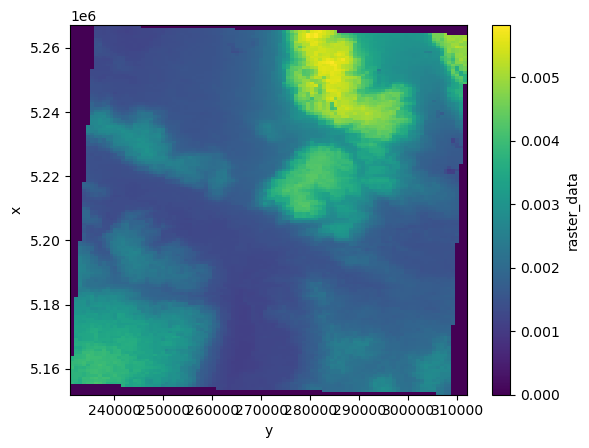

In [17]:
raster_ds_infil['raster_data'].mean(dim='time').plot()

#### Interpolate to the grid
Here we'll use nearest neighbor interpolation to resample our precipitation to the model grid.

In [18]:
# resample raster to cell centers defined by list of x and y coordinates

# get list of x and y coordinates from the grid
xx = modelgrid.ycellcenters[:, 0]
yy = modelgrid.xcellcenters[0, :]

# resample raster to cell centers
raster_ds_infil_resampled = raster_ds_infil.interp(x=xx, y=yy, method='nearest')
#raster_ds_infil_resampled =raster_ds_infil_resampled.to_dataarray()


In [19]:
raster_ds_infil_resampled

<xarray.Dataset>
Dimensions:      (time: 7451, x: 316, y: 405)
Coordinates:
  * time         (time) datetime64[ns] 2003-09-30 2003-10-01 ... 2024-03-11
  * x            (x) float64 5.224e+06 5.223e+06 ... 5.192e+06 5.192e+06
  * y            (y) float64 2.613e+05 2.614e+05 ... 3.016e+05 3.017e+05
Data variables:
    raster_data  (time, x, y) float64 0.0 0.0 0.0 0.0 ... 0.00851 0.00851 0.0

In [20]:
# get mean infiltration over the period of record
meaninfname = 'precipresampled.txt'
meaninfloc = os.path.join(gis_derived_path,meaninfname)
mean_infil = np.genfromtxt(meaninfloc)
# mean_infil = raster_ds_infil_resampled['raster_data'].mean(dim='time').values*.3
# plt.imshow(mean_infil)
# plt.colorbar()

In [21]:
# get portion of rasster_ds_infil_resampled that is greater than start_date and less than end_date
raster_ds_infil_resampled = raster_ds_infil_resampled.sel(time=slice(start_date,end_date))

# resample raster_ds to time intervals in days given by perlen
perlenstr = str(perlen) + 'D'
raster_ds_infil_resampled_sp = raster_ds_infil_resampled.resample(time=perlenstr).mean()

# add some numerical lubrication by setting all values less than a cutoff to a cutoff value
low_cutoff = 1e-6
raster_ds_infil_resampled_sp['raster_data'] = raster_ds_infil_resampled_sp['raster_data'].where(raster_ds_infil_resampled_sp['raster_data']>=low_cutoff, low_cutoff)

In [22]:
# smooth with 14 point moving average
raster_ds_infil_resampled_sp['raster_data'] = raster_ds_infil_resampled_sp['raster_data'].rolling(time=3, center=True, min_periods=1).mean()

In [23]:
#plot raster_ds_infil_resampled_sp for all stress periods
plot_stress_periods=0
if plot_stress_periods:
    for i in range(nper):
        plt.figure()
        raster_ds_infil_resampled_sp.isel(time=i)['raster_data'].plot()
        t_np = raster_ds_infil_resampled_sp.isel(time=i)['time'].values
        python_datetime = dt.datetime.utcfromtimestamp(t_np.astype('O') / 1e9)
        #t_str = dt.datetime.strftime(t_dt, '%Y-%m-%d')
        plt.title('Stress Period ' + str(i+1) + ', Time: ' + python_datetime.strftime('%Y-%m-%d'))

### Create spd for infiltration
Create the stress period dictionary for the infiltration.  The dictionary is keyed by the stress period number, and points to the infiltration array for that stress period.

In [24]:
# loop over all stress periods and write infiltration data
infil_spd = {0: mean_infil}
for i in range(1,nper):
    infil_spd[i] = raster_ds_infil_resampled_sp.isel(time=i)['raster_data'].values

infil_spd.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [25]:

# Load teh resampled mean evapotranspiration data
etresampled_file = 'etrresampled.txt'
etresampled_file = os.path.join(gis_derived_path,etresampled_file)
etresampled = np.genfromtxt(etresampled_file)
etr = {0: etresampled/10000, 1: etresampled/10000}


In [26]:
#####################################################
# Modify the UZF package
#####################################################


# set up new uzf package, use all object values currently used but update finf
uzf = flopy.modflow.ModflowUzf1(
    model=mf,
    capillaryuzet = False,
    finf = infil_spd,
    ietflg = 1,
    pet=etr,
    extdp = -2.5,
    #pet=0.0,
    etsquare=0.1,
    ipakcb = 1,
    irunbnd = strm_obj.irunbnd,
    irunflg = 1,
    iuzfbnd = mf.uzf.iuzfbnd,
    iuzfcb2 = 1,
    iuzfopt = 2,
    nosurfleak = False,
    nsets = 20,
    ntrail2 = 15,
    nuztop = 1,
    options = None,
    rejectsurfk = False,
    seepsurfk = False,
    specifysurfk = False,
    specifythti = False,
    specifythtr = False,
    surfdep = 1.0,
)

c:\Users\taylo\anaconda3\envs\flopy_forge\Lib\site-packages\flopy\mbase.py:659: UserWarning: Unit 19 of package UZF already in use.
  warn(
c:\Users\taylo\anaconda3\envs\flopy_forge\Lib\site-packages\flopy\mbase.py:668: UserWarning: Two packages of the same type, Replacing existing 'UZF' package.
  warn(


### Modify Solver Options
Solver is an issue..

In [27]:
print(mf.nwt)


    MODFLOW Nwt Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.mf.Modflow`) to which
        this package will be added.
    headtol : float
        is the maximum head change between outer iterations for solution of
        the nonlinear problem. (default is 1e-4).
    fluxtol : float
        is the maximum l2 norm for solution of the nonlinear problem.
        (default is 500).
    maxiterout : int
        is the maximum number of iterations to be allowed for solution of the
        outer (nonlinear) problem. (default is 100).
    thickfact : float
        is the portion of the cell thickness (length) used for smoothly
        adjusting storage and conductance coefficients to zero.
        (default is 1e-5).
    linmeth : int
        is a flag that determines which matrix solver will be used.
        A value of 1 indicates GMRES will be used
        A value of 2 indicates XMD will be used.
        (defau

In [28]:
##########################
# Modify the NWT package
##########################

mf.nwt.options = ["SIMPLE"]
mf.nwt.iprnwt = 1
#mf.nwt.headtol = 1e-3
mf.nwt.maxiterout = 100
#mf.nwt.thickfact = 0.1
#mf.nwt.maxbackiter = 50
mf.nwt.ibotav = 1

In [29]:
##########################
# Update SFR
##########################

#example values for now, but likely need to be tuned for the model later.

# stream roughness for the segments.  
# update roughch in segment data - all constant and set to 0.04 for now.  Can be tuned later.
mf.sfr.segment_data[0]["roughch"] = 0.04

# update strhc1 in reach data.
mf.sfr.reach_data["strhc1"] = 0.1

# route flow
mf.sfr.irtflg = 1


# print stream budget data
mf.sfr.istcb2 = 48



In [30]:
print(mf.oc)


    MODFLOW Output Control Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.mf.Modflow`) to which
        this package will be added.
    ihedfm : int
        is a code for the format in which heads will be printed.
        (default is 0).
    iddnfm : int
        is a code for the format in which drawdown will be printed.
        (default is 0).
    chedfm : string
        is a character value that specifies the format for saving heads.
        The format must contain 20 characters or less and must be a valid
        Fortran format that is enclosed in parentheses. The format must be
        enclosed in apostrophes if it contains one or more blanks or commas.
        The optional word LABEL after the format is used to indicate that
        each layer of output should be preceded with a line that defines the
        output (simulation time, the layer being output, and so forth). If
        there is no record 

In [31]:
##########################
# Modify the OC package
##########################

# output saved head 3 times per stress period
oc_spd = {(0,0): ['save head','save budget'],(0,first_nstp): ['save head','save budget']}
for i in range(1,nper):
    for j in range(0, nstp, int(nstp//3)):
        oc_spd[(i,j)] = ['save head','save budget']

# add last stress period and last time step to the dictionary
oc_spd[(nper-1,nstp-1)] = ['save head','save budget']

print(oc_spd)


mf.oc.stress_period_data = oc_spd


{(0, 0): ['save head', 'save budget'], (0, 365): ['save head', 'save budget'], (1, 0): ['save head', 'save budget'], (1, 7): ['save head', 'save budget'], (1, 14): ['save head', 'save budget'], (2, 0): ['save head', 'save budget'], (2, 7): ['save head', 'save budget'], (2, 14): ['save head', 'save budget'], (3, 0): ['save head', 'save budget'], (3, 7): ['save head', 'save budget'], (3, 14): ['save head', 'save budget'], (4, 0): ['save head', 'save budget'], (4, 7): ['save head', 'save budget'], (4, 14): ['save head', 'save budget'], (5, 0): ['save head', 'save budget'], (5, 7): ['save head', 'save budget'], (5, 14): ['save head', 'save budget'], (6, 0): ['save head', 'save budget'], (6, 7): ['save head', 'save budget'], (6, 14): ['save head', 'save budget'], (7, 0): ['save head', 'save budget'], (7, 7): ['save head', 'save budget'], (7, 14): ['save head', 'save budget'], (8, 0): ['save head', 'save budget'], (8, 7): ['save head', 'save budget'], (8, 14): ['save head', 'save budget'], (

In [32]:
##########################
# Offset the Model GRID to match location
##########################
# copy the coordinate information from the modelgrid we built in the Fishnet
mf.modelgrid.set_coord_info(
    xoff=modelgrid.xoffset, 
    yoff=modelgrid.yoffset
)

In [33]:
##########################
# Write Input Files
##########################
# change the path of the model and write to file
mf.change_model_ws(model_path)
mf.write_input()

In [ ]:
#######################################################
#RUN MODFLOW 
#######################################################
# mf.exe_name = 'mfnwt'
# success, buff = mf.run_model(silent=False)
# print(buff)


In [ ]:
#######################################################
#Visualize the solution
#######################################################
# define the headfile path
head_file = os.path.join(model_path, model_name+".hds")

# load the headfile
hds = flopy.utils.HeadFile(head_file)
# get all the head data
heads_all = hds.get_alldata()
times = hds.get_times()

# add elapsed time which is a float in days to start_date

# first create a vector of timedeltas in days from times
tdays = np.array([dt.timedelta(days=float(t)) for t in times])


# add elapsed time in days to start_date
model_times = start_date_ss + tdays

# loop through all model times and plot depth to water
plot_heads=1
if plot_heads:
    for i, t in enumerate(model_times):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=mf, ax=ax)
        pc = pmv.plot_array(mf.dis.top.array-heads_all[i,0,:,:])
        # pc.set_clim(50, 0)
        ib = pmv.plot_inactive()
        plt.colorbar(pc, shrink=0.7)
        # change model_time date time to string
        t_str = t.strftime("%Y-%m-%d")
        plt.title("Rattlesnake Creek depth to water at time = " + str(t_str))

Intersect the gauge point with the grid.

In [ ]:
#########
# read in shape file
#########

# read in shapefile
sf2 = sf.Reader(gage_file)
# get the first shape
first_shape = sf2.shapes()[0]
# get the first point
first_point = Point(first_shape.points)

# get intersecting cells
GaugeCells = ix.intersect(first_point)
pd.DataFrame(GaugeCells).head(3)

,cellids,ixshapes
0,"(275, 121)",POINT (273357.7523165369 5196047.25657051)


In [ ]:
GaugeCells['cellids'][0][0]

275

In [ ]:


sfrout = SfrFile(os.path.join(model_path, 'fort.48'))

dfsfr = sfrout.get_dataframe()



dfout = dfsfr[(dfsfr['row'] == GaugeCells['cellids'][0][0])&(dfsfr['column'] == GaugeCells['cellids'][0][1])]

dfout = dfsfr[(dfsfr['j'] == GaugeCells['cellids'][0][1])&(dfsfr['i'] == GaugeCells['cellids'][0][0])]

dfout.tail(3)
#dfout.head(3)
#sfrout.get_times()

c:\Users\taylo\anaconda3\envs\flopy_forge\Lib\site-packages\flopy\utils\sfroutputfile.py:174: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(**kwargs, on_bad_lines="skip")


,layer,row,column,segment,reach,Qin,Qaquifer,Qout,Qovr,Qprecip,Qet,stage,depth,width,Cond,gradient,kstpkper,k,i,j
708450,1,276,122,29,13,498770.0,-111.02,499130.0,245.4,0.0,0.0,989.549,0.3656,10.0,120.7,-0.9197,"(7, 365)",0,275,121
709097,1,276,122,29,13,494390.0,-110.91,494740.0,244.3,0.0,0.0,989.547,0.3637,10.0,120.7,-0.9188,"(14, 365)",0,275,121
709744,1,276,122,29,13,490690.0,-110.83,491040.0,243.3,0.0,0.0,989.545,0.3620,10.0,120.7,-0.9181,"(20, 365)",0,275,121


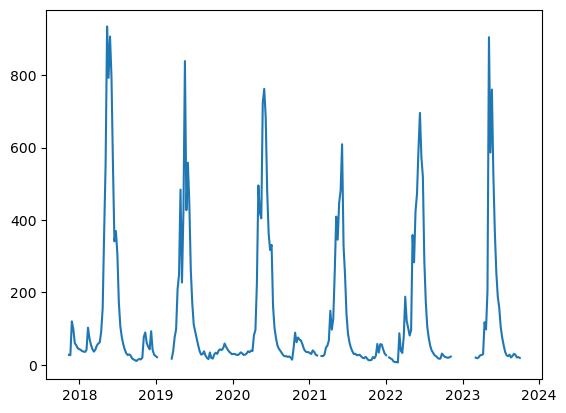

In [ ]:
gagedf = pd.read_csv('GageData.csv',skiprows=1)
gagedf['Timestamp']=pd.to_datetime(gagedf['Timestamp'], format='%Y-%m-%d %H:%M')
# gagedf.head()
# gagedf.Timestamp
gagedf.set_index('Timestamp',inplace=True)
# gagedf.head()
gagedf = gagedf.drop('Approval Name',axis=1).resample('W').mean()
gagedf.head()
plt.plot(gagedf.index,gagedf['Discharge.discharge@76M 01100 (ft^3/s)'])

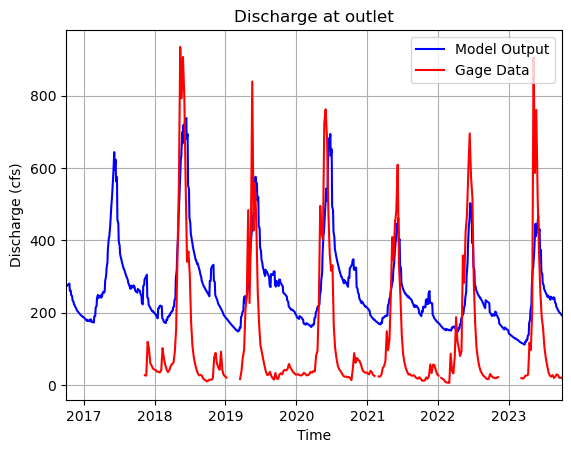

In [ ]:
# plot dfout['Qout'
plt.plot(model_times, dfout['Qout']/86400*3.24**3,'b-', label= 'Model Output')
plt.plot(gagedf.index,gagedf['Discharge.discharge@76M 01100 (ft^3/s)'],'-r',label='Gage Data')
plt.title('Discharge at outlet')
plt.xlabel('Time')
plt.ylabel('Discharge (cfs)')
plt.xlim(start_date, end_date)
# add grid
plt.grid()
plt.legend()